# Dipper Detection 
Goal: This notebook is a copy of Kyle Boone's `dipper_detection.ipynb`. I have added comments and narrative to understand the code and for future reference. 

## Setup
### Some imports...
Note:
* The `getpass` module provides a secure way to handle the password prompts where programs interact with the users via the terminal
* The `pyspark.sql.functions` documentation at http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#module-pyspark.sql.functions
* `dipper` is a python src module

In [1]:
import getpass
import numpy as np
import matplotlib.pyplot as plt

import axs
import pyspark.sql.functions as sparkfunc 
import dipper

In [2]:
%matplotlib notebook # 'magic' function

### Begin a spark session...

In [3]:
def spark_start(local_dir):
    from pyspark.sql import SparkSession
    
    spark = (
            SparkSession.builder
            .appName("LSD2")
            .config("spark.sql.warehouse.dir", local_dir)
            .config('spark.master', "local[20]")
            .config('spark.driver.memory', '8G') # 128
            .config('spark.local.dir', local_dir)
            .config('spark.memory.offHeap.enabled', 'true')
            .config('spark.memory.offHeap.size', '4G') # 256
            .config("spark.sql.execution.arrow.enabled", "true")
            .config("spark.driver.maxResultSize", "6G")
            .config("spark.driver.extraJavaOptions", f"-Dderby.system.home={local_dir}")
            .enableHiveSupport()
            .getOrCreate()
    )   

    return spark

username = getpass.getuser()
spark_session = spark_start(f"/epyc/users/{username}/spark-tmp/")

catalog = axs.AxsCatalog(spark_session)

In [4]:
spark_session

## Select the best dippers
Load a catalog where we have used loose selection cuts to find dippers and measured lots of different dip properties.
This has 4.5M lightcurves.

In [6]:
wtf = catalog.load('wtf_march2020_full_3')

Select the good dippers with a set of cuts tuned to pull out what we are looking for.

In [7]:
cut_wtf = (
    wtf
    .where(
        # Line 247 -- 
        (sparkfunc.col("dip.significance") >= 5)
        
        # Line 650
        # Count how many significant observations are in the window
        # (Isn't this >= 5 in the Analogs paper?)
        & (sparkfunc.col("dip.significant_observation_count") >= 3)
        
        # Line 715
        # Find the largest gap in observations near the dip
        # gap being in time, the fraction is the ratio of time gap to mag gap
        & (sparkfunc.col("dip.max_gap_fraction") < 0.8)
        
        # Line 756
        # core length (?) in what units ?
        & (sparkfunc.col("dip.core_length") >= 0.5)
        
        #
        & (sparkfunc.col("dip.core_not_significant_fraction") < 0.2)
        
        #
        & (sparkfunc.col("dip.core_significant_count") > 3.)
        
        #
        & (sparkfunc.col("dip.ref_pull_std") < 2.)
        
        #
        & (sparkfunc.col("dip.ref_length_fraction_before") > 0.5)
        
        #
        & (sparkfunc.col("dip.ref_length_fraction_after") > 0.5)
    )
)
best_dippers = cut_wtf.sort(cut_wtf['dip.significance'].desc()).head(1000)

In [8]:
cut_wtf.count()

73903

In [10]:
wtf.count()

9246632

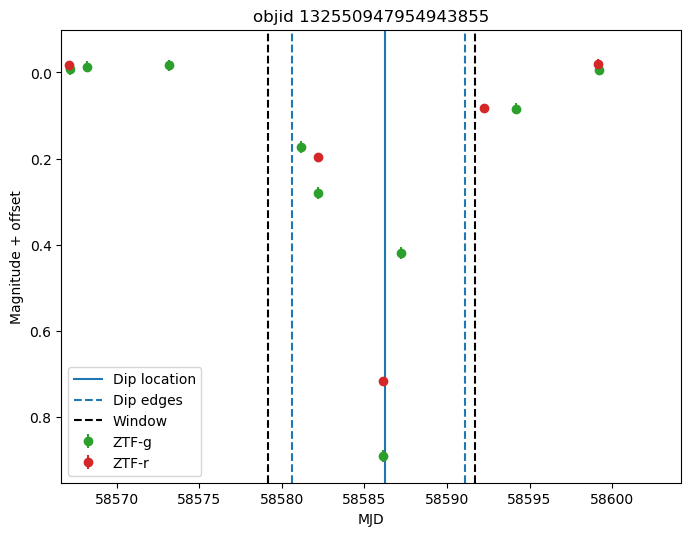

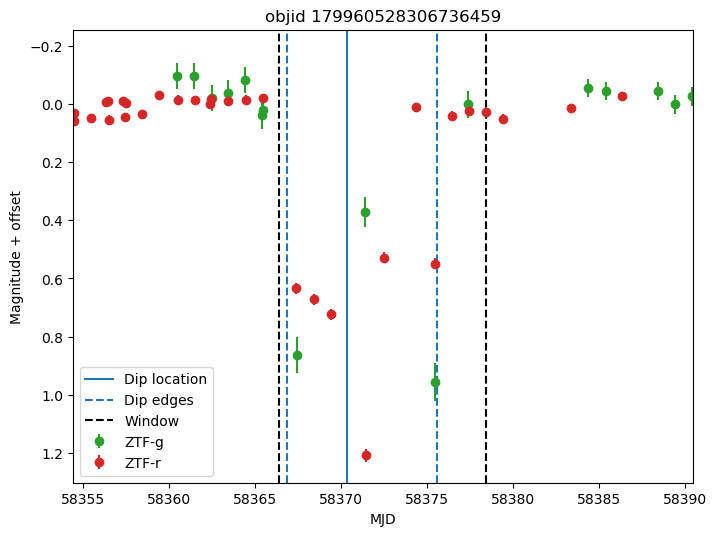

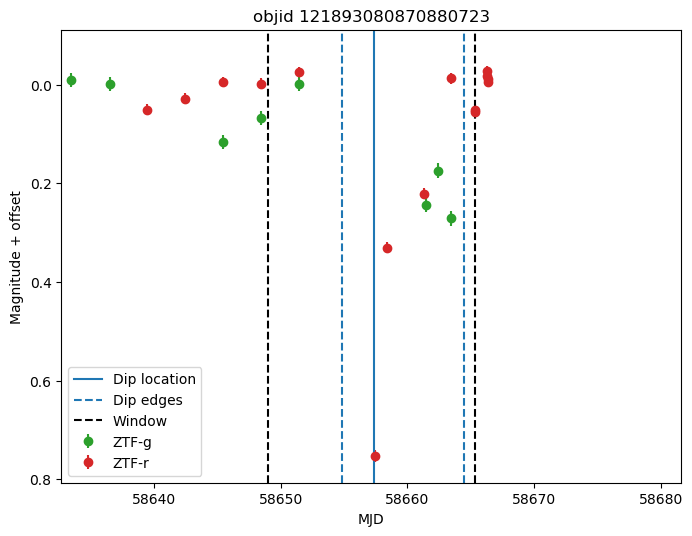

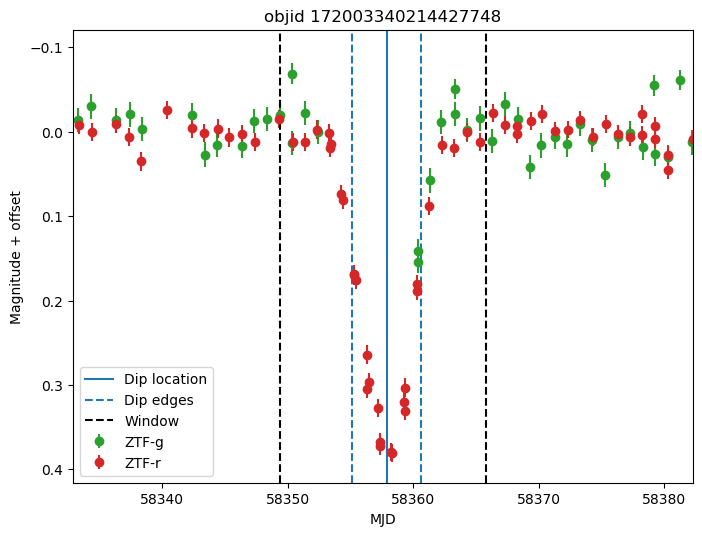

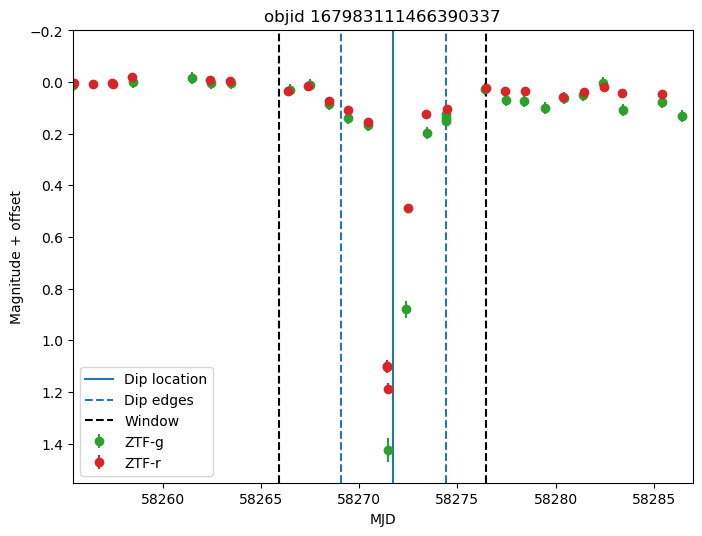

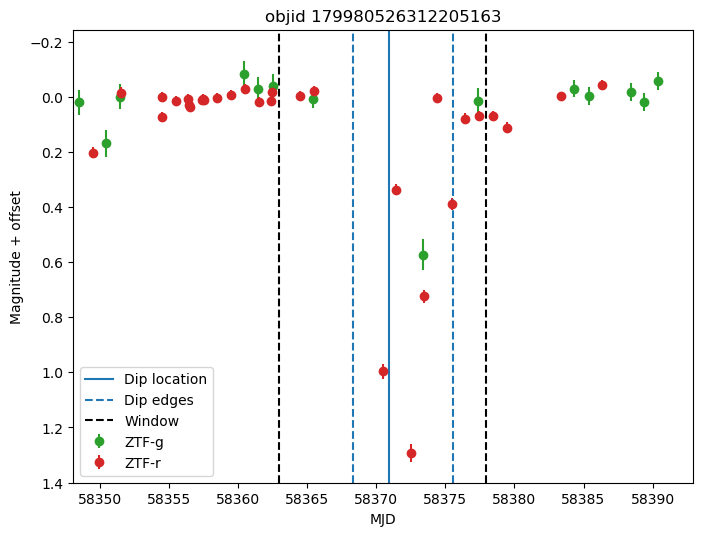

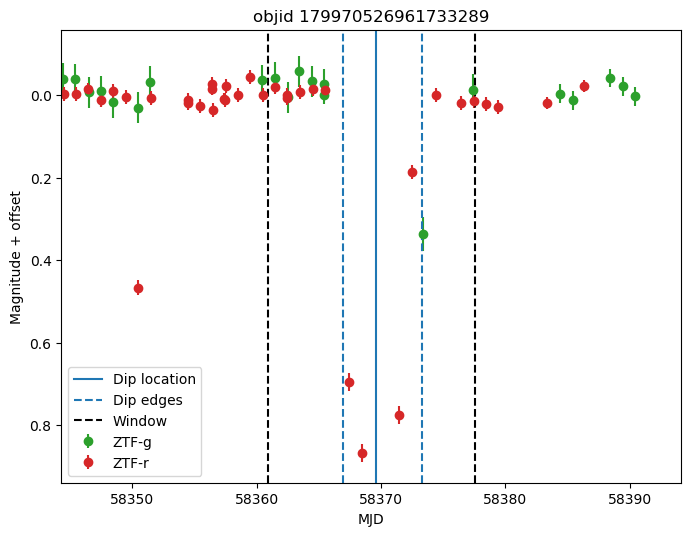

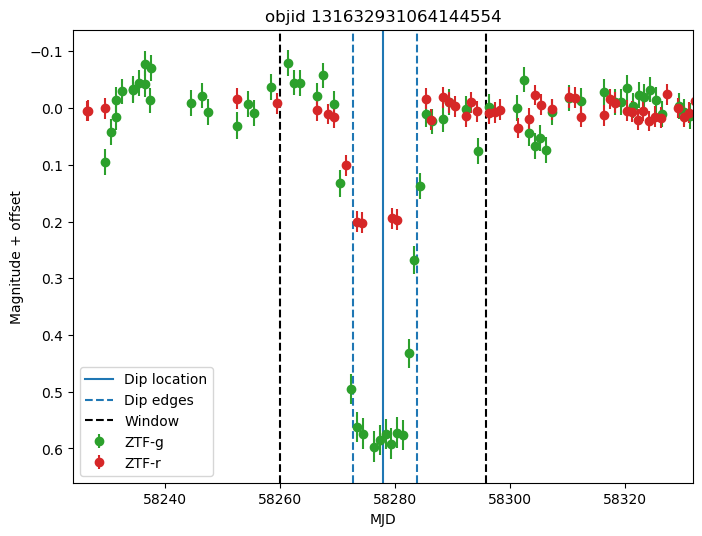

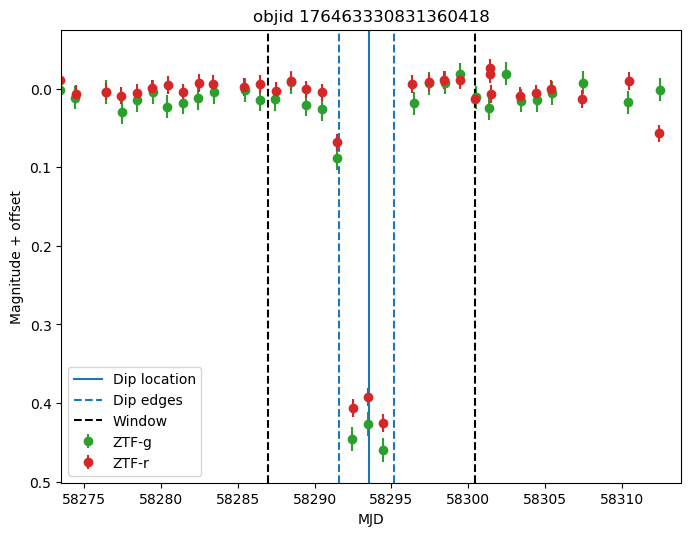

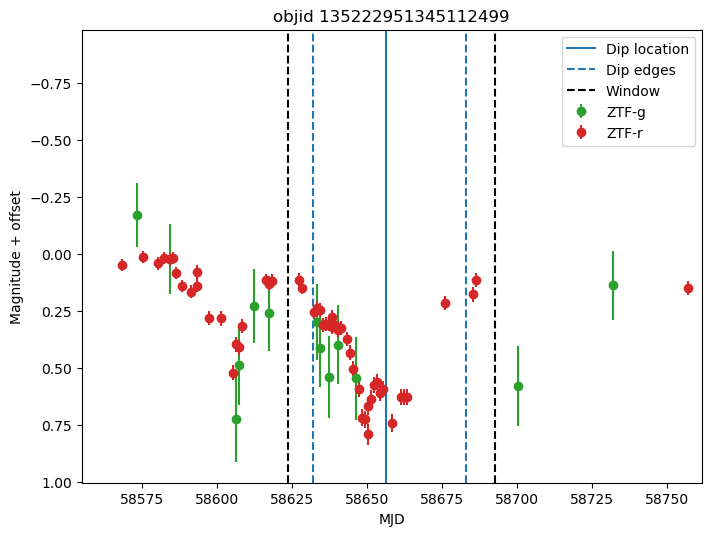

In [11]:
for i in range(10):
    dipper.plot_light_curve(best_dippers[i], zoom=True, verbose=False)